# Dominik Czech - Lab 4 - PyTorch Model Training and Hyperparameter Tuning (SGD, Adam, RMSprop

In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from copy import deepcopy


from lab1_4.fetch_and_preprocess import fetch_heart_data, preprocess_heart_data


## Fetch data and preprocess

In [2]:
# fetch dataset 
df = fetch_heart_data()

#preprocess
X_processed, y = preprocess_heart_data(df, scale=True)

# 0 - no heart disease, 1 - heart disease (no matter which type)
y_binary = df['num'].apply(lambda x: 1 if x > 0 else 0)

# --- stratified 60/20/20 split ---
test_size = 0.20
val_size = 0.20  # final fraction for validation

# 1) hold out test first
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_processed, y_binary, test_size=test_size, stratify=y_binary, random_state=42
)

# 2) split train into train/val (adjust val size relative to remaining)
val_size_adj = val_size / (1.0 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_adj, stratify=y_trainval, random_state=42
)

# --- ensure correct NumPy shapes for the network ---
X_train_np = np.asarray(X_train, dtype=np.float32)
y_train_np = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)

X_val_np = np.asarray(X_val, dtype=np.float32)
y_val_np = np.asarray(y_val, dtype=np.float32).reshape(-1, 1)

X_test_np = np.asarray(X_test, dtype=np.float32)
y_test_np = np.asarray(y_test, dtype=np.float32)  # flat for accuracy


## Define MLP model

In [3]:
class MLP(nn.Module):
    """
    Fully-connected network that returns logits (no Sigmoid).
    Use with nn.BCEWithLogitsLoss and compute accuracy by applying Sigmoid at eval.
    """
    def __init__(self, input_size, hidden_sizes, weight_std=0.01, bias_init=0.0, loss_fn=None, loss_fn_derivative=None):
        super().__init__()
        layers = []
        in_dim = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU(inplace=True))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        layers.append(nn.Sigmoid()) # Output layer with Sigmoid for binary classification
        self.network = nn.Sequential(*layers)
        self._init_weights(weight_std, bias_init)

    def _init_weights(self, weight_std, bias_init):
        for m in self.network:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=weight_std)
                nn.init.constant_(m.bias, bias_init)

    def forward(self, x):
        return self.network(x)  


In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Helper functions

In [15]:
def plot_history(
    histories,
    title="Training history",
    loss_cap=None,          # clip losses above this value
    loss_ylim=None,         # tuple (ymin, ymax) for loss axis
    acc_ylim=None,          # tuple (ymin, ymax) for accuracy axis
    log_loss=False          # use log scale for loss axis instead of clipping
):
    import matplotlib.pyplot as plt
    import numpy as np

    # Accept both a single history dict or dict[label] -> history
    if isinstance(histories, dict) and histories and isinstance(next(iter(histories.values())), dict):
        items = histories.items()
    else:
        items = [("run", histories)]

    plt.figure(figsize=(12,5))

    # ----- Loss subplot -----
    plt.subplot(1,2,1)
    for label, h in items:
        tl = list(h["train_loss"])
        vl = list(h["val_loss"])
        # Clip if requested
        if loss_cap is not None:
            tl = [min(x, loss_cap) for x in tl]
            vl = [None if x is None else min(x, loss_cap) for x in vl]
        epochs = range(1, len(tl)+1)
        plt.plot(epochs, tl, label=f"{label} train")
        if any(x is not None for x in vl):
            plt.plot(epochs, [x if x is not None else np.nan for x in vl], label=f"{label} val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} - Loss")
    if log_loss:
        plt.yscale("log")
    if loss_ylim is not None:
        plt.ylim(*loss_ylim)
    plt.legend()

    # ----- Accuracy subplot -----
    plt.subplot(1,2,2)
    for label, h in items:
        ta = h["train_acc"]
        va = h["val_acc"]
        epochs = range(1, len(ta)+1)
        plt.plot(epochs, ta, label=f"{label} train")
        if any(x is not None for x in va):
            plt.plot(epochs, [x if x is not None else np.nan for x in va], label=f"{label} val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} - Accuracy")
    if acc_ylim is not None:
        plt.ylim(*acc_ylim)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def make_dataloaders(
    X_train_np, y_train_np,
    X_val_np=None, y_val_np=None,
    batch_size=32, shuffle=True
):
    X_train_t = torch.from_numpy(X_train_np.astype(np.float32))
    y_train_t = torch.from_numpy(y_train_np.astype(np.float32))  # shape (N,1)
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)

    val_loader = None
    if X_val_np is not None and y_val_np is not None:
        X_val_t = torch.from_numpy(X_val_np.astype(np.float32))
        y_val_t = torch.from_numpy(y_val_np.astype(np.float32))
        val_ds = TensorDataset(X_val_t, y_val_t)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def batch_accuracy(probs, targets):
    # probs: (N,1) in [0,1] (Sigmoid output), targets: (N,1) floats {0,1}
    preds = (probs >= 0.5).to(dtype=torch.float32)
    correct = (preds == targets).sum().item()
    return correct

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        probs = model(xb)
        loss = loss_fn(probs, yb) 
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_correct += batch_accuracy(probs, yb)
        total_samples += bs
    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)
    return avg_loss, avg_acc

def train_one_epoch(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        probs = model(xb)
        loss = loss_fn(probs, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        bs = yb.size(0)
        total_loss += loss.item() * bs
        total_correct += batch_accuracy(probs.detach(), yb)
        total_samples += bs
    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)
    return avg_loss, avg_acc

def train_model(model, loss_fn, optimizer, train_loader, val_loader=None, epochs=50, device="cpu", verbose=True):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    model.to(device)
    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        history["train_loss"].append(float(tr_loss))
        history["train_acc"].append(float(tr_acc))

        if val_loader is not None:
            val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
            history["val_loss"].append(float(val_loss))
            history["val_acc"].append(float(val_acc))
        else:
            history["val_loss"].append(None)
            history["val_acc"].append(None)

        if verbose:
            msg = f"Epoch {epoch+1}/{epochs} train_loss={tr_loss:.4f} train_acc={tr_acc:.3f}"
            if val_loader is not None:
                msg += f" val_loss={val_loss:.4f} val_acc={val_acc:.3f}"
            print(msg)
    return history

## Compare optimizers: SGD, Adam, RMSprop

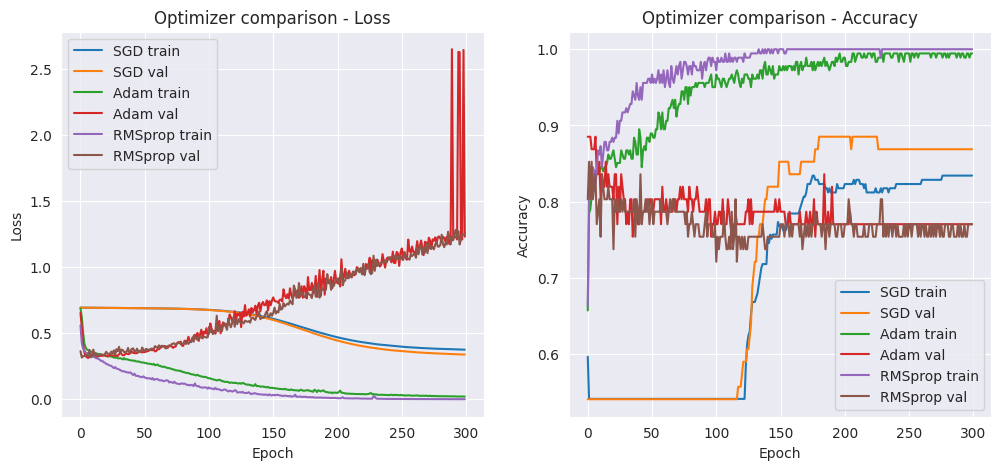

In [8]:
BATCH_SIZE = 32
INPUT_SIZE = X_train_np.shape[1]
HIDDEN_SIZES_PREV = [16]
WEIGHT_STD_PREV, BIAS_INIT_PREV = 0.01, 0.0
LEARNING_RATE_PREV = 0.01
EPOCHS = 300


# --- Build loaders from existing NumPy arrays defined above ---
torch.manual_seed(42); np.random.seed(42)
train_loader, val_loader = make_dataloaders(X_train_np, y_train_np, X_val_np, y_val_np, batch_size=BATCH_SIZE)



# Base initialization snapshot
base_model = MLP(input_size=INPUT_SIZE, hidden_sizes=HIDDEN_SIZES_PREV, weight_std=WEIGHT_STD_PREV, bias_init=BIAS_INIT_PREV)
base_state = deepcopy(base_model.state_dict())

loss_fn = nn.BCELoss()

optim_specs = {
    "SGD": lambda m: torch.optim.SGD(m.parameters(), lr=LEARNING_RATE_PREV),
    "Adam":        lambda m: torch.optim.Adam(m.parameters(), lr=LEARNING_RATE_PREV),
    "RMSprop":     lambda m: torch.optim.RMSprop(m.parameters(), lr=LEARNING_RATE_PREV)
}

histories = {}
for name, make_opt in optim_specs.items():
    model = MLP(input_size=INPUT_SIZE, hidden_sizes=HIDDEN_SIZES_PREV, weight_std=WEIGHT_STD_PREV, bias_init=BIAS_INIT_PREV)
    model.load_state_dict(base_state)  # identical start
    optimizer = make_opt(model)
    h = train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=EPOCHS, device=device, verbose=False)
    histories[name] = h

plot_history(histories, title="Optimizer comparison")

The test ran with the best hyperparameters from the previous grid search shows us that different optimizers might require different parameters to perform optimally.
- After epoch ~50 Adam and RMSprop, showed big overfitting with the previous best parameters, drastically increasing the validation loss and losing validation accuracy.
- SGD with the basic momentum slowly improved both training and validation accuracy, however it did not converge to the best possible performance within 300 epochs.

## Learning rate sweep for Adam and RMSprop

  optimizer      lr hidden_sizes  params  train_loss  train_acc  val_loss  \
0      Adam  0.0001         [16]     433    0.390920   0.823204  0.361379   
1      Adam  0.0010         [16]     433    0.298995   0.861878  0.341802   
2      Adam  0.0100         [16]     433    0.004058   1.000000  1.035152   
3      Adam  0.1000         [16]     433    0.106204   0.955801  1.309786   

    val_acc  test_loss  test_acc  
0  0.868852   0.313964  0.901639  
1  0.786885   0.351461  0.852459  
2  0.704918   0.993108  0.803279  
3  0.704918   6.091580  0.737705  
Adam best by val_loss: lr=0.001 val_loss=0.3418 val_acc=0.787 test_acc=0.852
Adam best by val_acc:  lr=0.0001 val_loss=0.3614 val_acc=0.869 test_acc=0.902


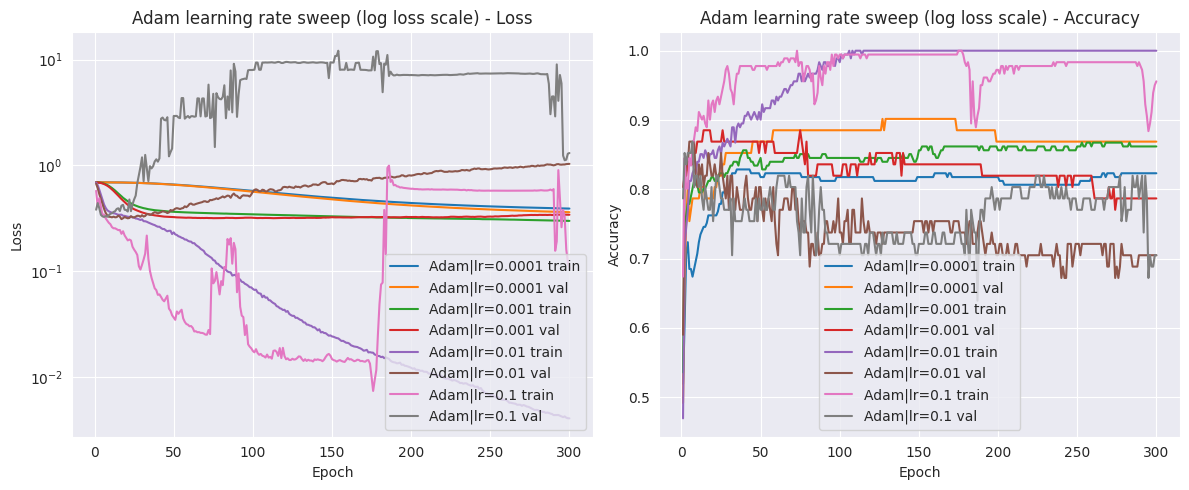

  optimizer      lr hidden_sizes  params  train_loss  train_acc  val_loss  \
0   RMSprop  0.0001         [16]     433    0.403064   0.823204  0.374260   
1   RMSprop  0.0010         [16]     433    0.281959   0.883978  0.334621   
2   RMSprop  0.0100         [16]     433    0.002916   1.000000  1.142576   
3   RMSprop  0.1000         [16]     433    0.589847   0.972376  0.654647   

    val_acc  test_loss  test_acc  
0  0.868852   0.324287  0.901639  
1  0.770492   0.349547  0.868852  
2  0.737705   2.411717  0.836066  
3  0.852459   2.741428  0.868852  
RMSprop best by val_loss: lr=0.001 val_loss=0.3346 val_acc=0.770 test_acc=0.869
RMSprop best by val_acc:  lr=0.0001 val_loss=0.3743 val_acc=0.869 test_acc=0.902


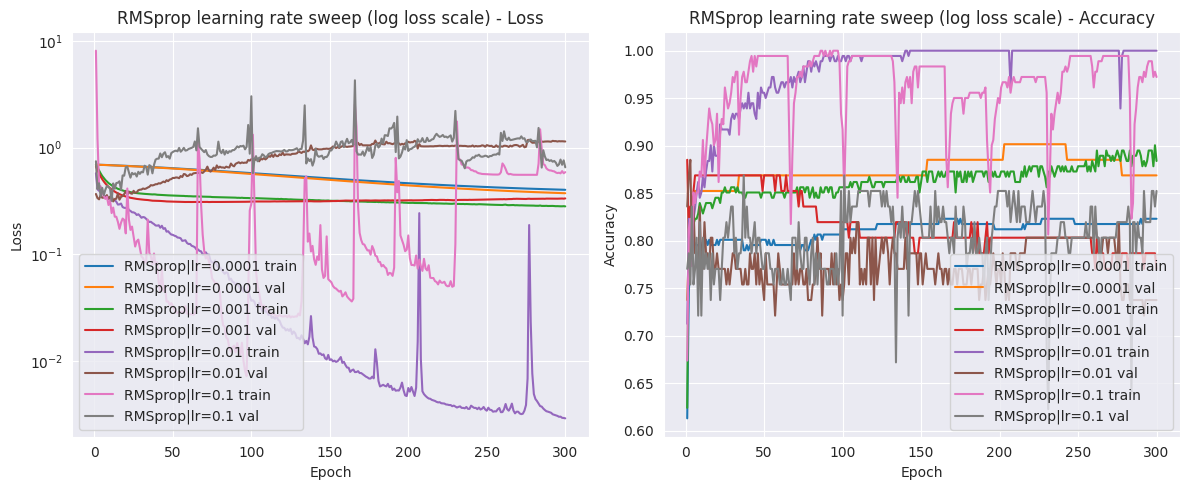

In [19]:
# Ensure test_loader (reshape targets to (N,1))
X_test_t = torch.from_numpy(X_test_np.astype(np.float32))
y_test_t = torch.from_numpy(y_test_np.reshape(-1, 1).astype(np.float32))
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=BATCH_SIZE, shuffle=False)

loss_fn = nn.BCELoss()

def make_model(hidden_sizes):
    return MLP(
        input_size=INPUT_SIZE,
        hidden_sizes=hidden_sizes,
        weight_std=WEIGHT_STD_PREV,
        bias_init=BIAS_INIT_PREV
    )

def run_lr_sweep_for_optimizer(
    opt_name: str,
    opt_factory_fn,              # function(model, lr) -> optimizer
    lrs,
    hidden_sizes,
    epochs=EPOCHS,
    seed=42
):
    histories = {}
    rows = []
    for i, lr in enumerate(lrs):
        torch.manual_seed(seed + i)
        np.random.seed(seed + i)

        model = make_model(hidden_sizes)
        optimizer = opt_factory_fn(model, lr)

        hist = train_model(
            model, loss_fn, optimizer,
            train_loader, val_loader,
            epochs=epochs, device=device, verbose=False
        )
        label = f"{opt_name}|lr={lr:g}"
        histories[label] = hist

        train_loss = hist["train_loss"][-1]
        train_acc = hist["train_acc"][-1]
        val_loss = hist["val_loss"][-1]
        val_acc = hist["val_acc"][-1]

        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)

        params = sum(p.numel() for p in model.parameters())
        rows.append({
            "optimizer": opt_name,
            "lr": lr,
            "hidden_sizes": str(hidden_sizes),
            "params": int(params),
            "train_loss": float(train_loss),
            "train_acc": float(train_acc),
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc)
        })

    df = pd.DataFrame(rows).sort_values("lr").reset_index(drop=True)
    return histories, df

def report_best(df, opt_name):
    best_loss_row = df.loc[df["val_loss"].idxmin()]
    best_acc_row = df.loc[df["val_acc"].idxmax()]
    print(f"{opt_name} best by val_loss: lr={best_loss_row['lr']:.5g} "
          f"val_loss={best_loss_row['val_loss']:.4f} val_acc={best_loss_row['val_acc']:.3f} "
          f"test_acc={best_loss_row['test_acc']:.3f}")
    print(f"{opt_name} best by val_acc:  lr={best_acc_row['lr']:.5g} "
          f"val_loss={best_acc_row['val_loss']:.4f} val_acc={best_acc_row['val_acc']:.3f} "
          f"test_acc={best_acc_row['test_acc']:.3f}")

# Learning rates to test (log + mid refinements)
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]

# Choose a representative architecture (adjust if needed)
arch = [16]

# Adam sweep
adam_histories, adam_df = run_lr_sweep_for_optimizer(
    "Adam",
    lambda m, lr: torch.optim.Adam(m.parameters(), lr=lr, weight_decay=1e-4),
    learning_rates,
    arch,
    epochs=EPOCHS,
    seed=100
)
print(adam_df)
report_best(adam_df, "Adam")
plot_history(adam_histories, title="Adam learning rate sweep (log loss scale)", log_loss=True)

# RMSprop sweep
rms_histories, rms_df = run_lr_sweep_for_optimizer(
    "RMSprop",
    lambda m, lr: torch.optim.RMSprop(m.parameters(), lr=lr, weight_decay=1e-4),
    learning_rates,
    arch,
    epochs=EPOCHS,
    seed=200
)
print(rms_df)
report_best(rms_df, "RMSprop")
plot_history(rms_histories, title="RMSprop learning rate sweep (log loss scale)", log_loss=True)

The learning rate sweep for both Adam and RMSprop optimizers on the [16] architecture reveals the following insights:
- Both optimizers require way smaller learning rates than SGD to perform well on this task.
- Both optimizers achieved the best val_accuracy of 0.867 with a learning rate of 0.001, indicating that this learning rate is optimal for the given architecture and dataset. Higher rates eventually lead to overfitting and instability.
- 300 epochs were not sufficient for convergence at the smallest learning rate of 0.0001, suggesting that longer training might yield better results at lower rates.

In [27]:
ADAM_BEST_LR = 0.0001
RMSPROP_BEST_LR = 0.0001

EPOCHS = 600

## Architecture sweep with Adam and RMSprop

   optimizer        arch  params  train_loss  train_acc  val_loss   val_acc  \
0       Adam     [16, 8]     561    0.352841   0.850829  0.310968  0.836066   
1       Adam     [32, 8]    1105    0.330637   0.861878  0.314076  0.852459   
2       Adam        [32]     865    0.346339   0.839779  0.316534  0.836066   
3       Adam        [16]     433    0.357267   0.839779  0.325136  0.836066   
4       Adam     [16, 4]     489    0.356336   0.834254  0.328594  0.836066   
5       Adam         [8]     217    0.382794   0.839779  0.366830  0.885246   
6       Adam         [4]     109    0.404008   0.834254  0.370630  0.868852   
7       Adam         [2]      55    0.444846   0.812155  0.422376  0.885246   
8       Adam  [16, 8, 4]     593    0.461321   0.861878  0.471321  0.852459   
9       Adam   [8, 8, 4]     321    0.475156   0.839779  0.479191  0.885246   
10      Adam      [8, 4]     249    0.481358   0.845304  0.483625  0.885246   
11      Adam   [4, 4, 4]     149    0.508128   0.850

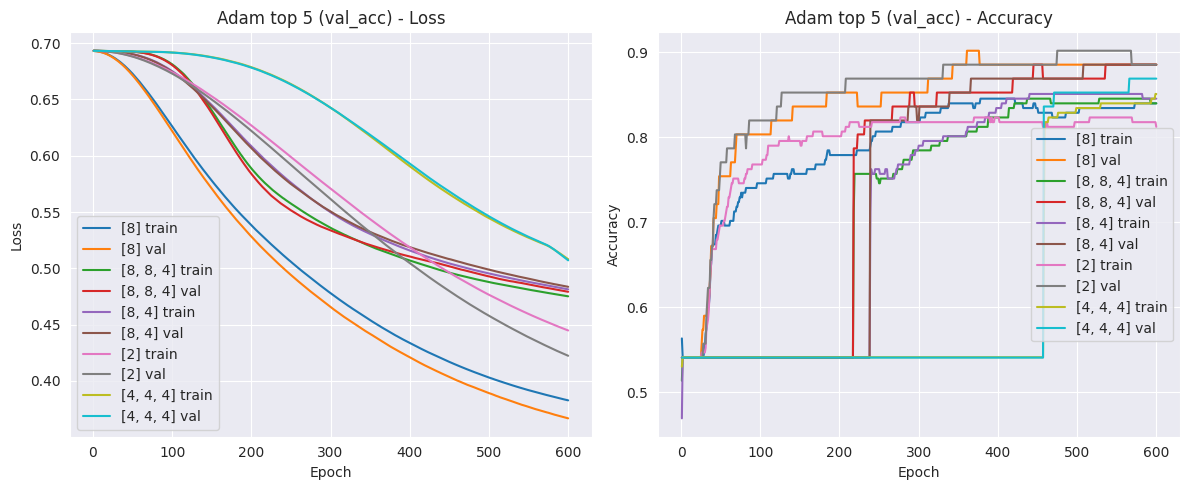

RMSprop top 5 by val_acc: ['[2]', '[16, 8, 4]', '[4]', '[8]', '[8, 4]']


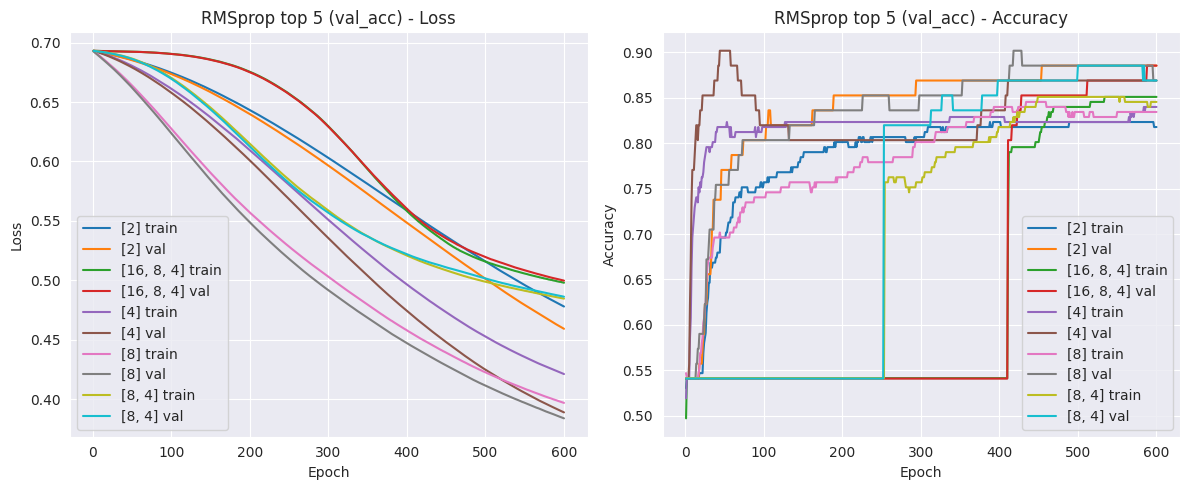

Adam top 10 by val_acc: ['[8]', '[8, 8, 4]', '[8, 4]', '[2]', '[4, 4, 4]', '[4]', '[32, 8]', '[16, 8, 4]', '[16, 8]', '[16, 4]']


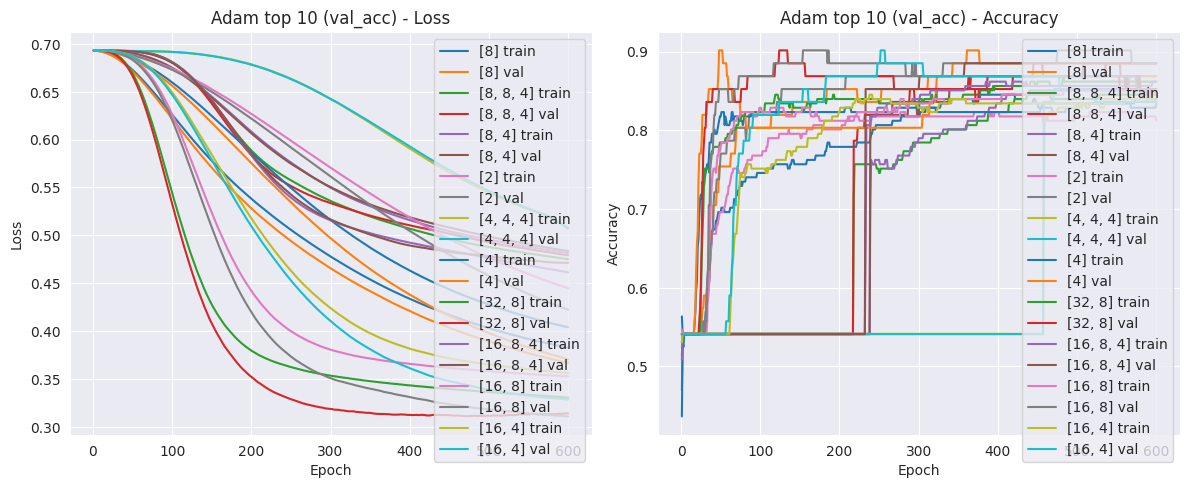

RMSprop top 10 by val_acc: ['[2]', '[16, 8, 4]', '[4]', '[8]', '[8, 4]', '[8, 8, 4]', '[16, 8]', '[16]', '[16, 4]', '[32, 8]']


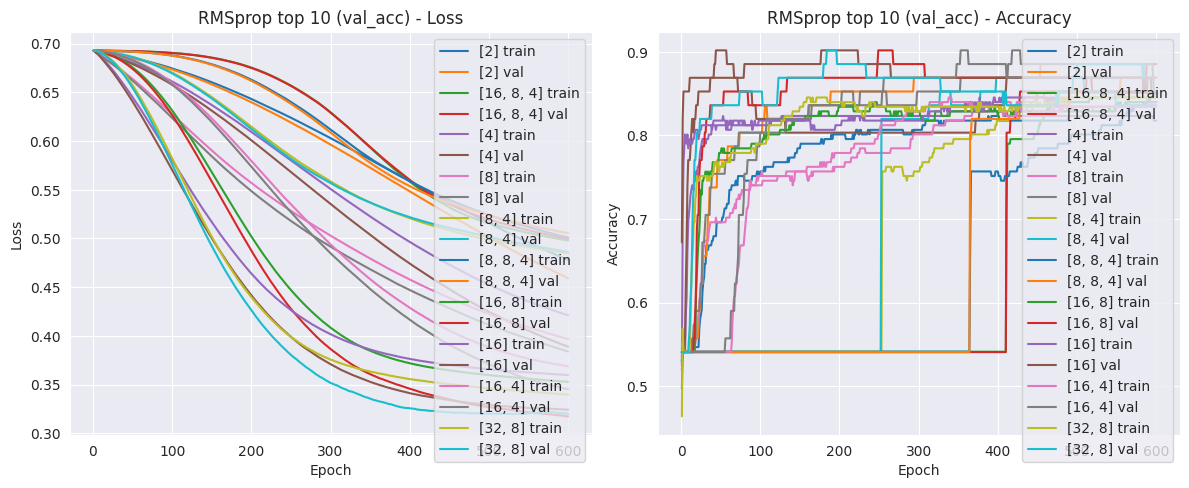

In [33]:
loss_fn = nn.BCELoss()

def make_model_arch(hidden_sizes):
    return MLP(
        input_size=INPUT_SIZE,
        hidden_sizes=hidden_sizes,
        weight_std=WEIGHT_STD_PREV,
        bias_init=BIAS_INIT_PREV
    )

def arch_label(hidden_sizes):
    return f"{hidden_sizes}"

def run_arch_sweep(arch_list, optim_specs, epochs=EPOCHS, seed=123):
    histories_by_opt = {opt_name: {} for opt_name in optim_specs.keys()}
    rows = []
    for idx, arch in enumerate(arch_list):
        torch.manual_seed(seed + idx)
        np.random.seed(seed + idx)
        base_model = make_model_arch(arch)
        base_state = deepcopy(base_model.state_dict())
        for opt_name, opt_factory in optim_specs.items():
            model = make_model_arch(arch)
            model.load_state_dict(base_state)
            optimizer = opt_factory(model)
            hist = train_model(model, loss_fn, optimizer, train_loader, val_loader,
                               epochs=epochs, device=device, verbose=False)
            label = arch_label(arch)
            histories_by_opt[opt_name][label] = hist
            train_loss, train_acc = hist["train_loss"][-1], hist["train_acc"][-1]
            val_loss, val_acc = hist["val_loss"][-1], hist["val_acc"][-1]
            test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
            params = sum(p.numel() for p in model.parameters())
            rows.append({
                "optimizer": opt_name,
                "arch": label,
                "params": int(params),
                "train_loss": float(train_loss),
                "train_acc": float(train_acc),
                "val_loss": float(val_loss),
                "val_acc": float(val_acc),
                "test_loss": float(test_loss),
                "test_acc": float(test_acc)
            })
    df = pd.DataFrame(rows).sort_values(["optimizer","val_loss"]).reset_index(drop=True)
    return histories_by_opt, df

def report_best_per_optimizer(df):
    for opt_name in df["optimizer"].unique():
        sub = df[df["optimizer"] == opt_name]
        best_loss = sub.loc[sub["val_loss"].idxmin()]
        best_acc = sub.loc[sub["val_acc"].idxmax()]
        print(f"{opt_name} best val_loss: arch={best_loss['arch']} "
              f"val_loss={best_loss['val_loss']:.4f} val_acc={best_loss['val_acc']:.3f} test_acc={best_loss['test_acc']:.3f}")
        print(f"{opt_name} best val_acc:  arch={best_acc['arch']} "
              f"val_loss={best_acc['val_loss']:.4f} val_acc={best_acc['val_acc']:.3f} test_acc={best_acc['test_acc']:.3f}")
        print("-" * 60)

def plot_top_k_by_val_accuracy(histories_by_opt, results_df, k=5, loss_cap=5):
    for opt_name in histories_by_opt.keys():
        sub = results_df[results_df["optimizer"] == opt_name].sort_values("val_acc", ascending=False).head(k)
        labels = sub["arch"].tolist()
        selected = {lbl: histories_by_opt[opt_name][lbl] for lbl in labels}
        print(f"{opt_name} top {k} by val_acc: {labels}")
        plot_history(selected, title=f"{opt_name} top {k} (val_acc)", loss_cap=loss_cap)

# Architectures
arch_list = [
    [1], [2], [4], [8], [16], [32],
    [8, 4], [16, 4], [16, 8], [32, 8],
    [4, 4, 4], [8, 8, 4], [16, 8, 4]
]

WD = 1e-4
optim_specs = {
    "Adam":    lambda m: torch.optim.Adam(m.parameters(), lr=ADAM_BEST_LR, weight_decay=WD),
    "RMSprop": lambda m: torch.optim.RMSprop(m.parameters(), lr=RMSPROP_BEST_LR, weight_decay=WD)
}

histories_by_opt, arch_results_df = run_arch_sweep(arch_list, optim_specs, epochs=EPOCHS, seed=2024)
print(arch_results_df)
report_best_per_optimizer(arch_results_df)

# Plot only top 5 by validation accuracy for each optimizer to reduce clutter
plot_top_k_by_val_accuracy(histories_by_opt, arch_results_df, k=5)

# Plot top 10 by validation accuracy for each optimizer to see more details on how the architectures behaved
plot_top_k_by_val_accuracy(histories_by_opt,arch_results_df, k = 10)


The architecture sweep with Adam and RMSprop optimizers reveals several insights:
- Architectures with wider first layers (16-32) learn faster at the beginning, however narrower or deeper architetures eventually outperform them.
- The best performing architectures are either shallow and narrow (2-8 neurons) or deeper with moderate width (3 layers of 4-8 neurons).
- Multiple architectures achieved the same test accuracy of 0.901639, with similar 85%+ validation accuracy, indicating that several configurations can effectively model the data.


In [34]:
ADAM_BEST_HS = [8]
RMSPROP_BEST_HS = [8]

# SGD momentum sweep

  optimizer  arch    lr  momentum  params  train_loss  train_acc  val_loss  \
0       SGD  [16]  0.01      0.00     433    0.352092   0.839779  0.331931   
1       SGD  [16]  0.01      0.99     433    0.170404   0.972376  0.364006   
2       SGD  [16]  0.01      0.50     433    0.318468   0.861878  0.322530   
3       SGD  [16]  0.01      0.90     433    0.210827   0.928177  0.439205   
4       SGD  [16]  0.01      0.95     433    0.189611   0.950276  0.422670   

    val_acc  test_loss  test_acc  
0  0.836066   0.305298  0.901639  
1  0.836066   0.375846  0.836066  
2  0.819672   0.319771  0.868852  
3  0.770492   0.399709  0.770492  
4  0.737705   0.416829  0.786885  
SGD best by val_loss: m=0.500lr=0.01 val_loss=0.3225 val_acc=0.820 test_acc=0.869
SGD best by val_acc:  m=0.000lr=0.01 val_loss=0.3319 val_acc=0.836 test_acc=0.902


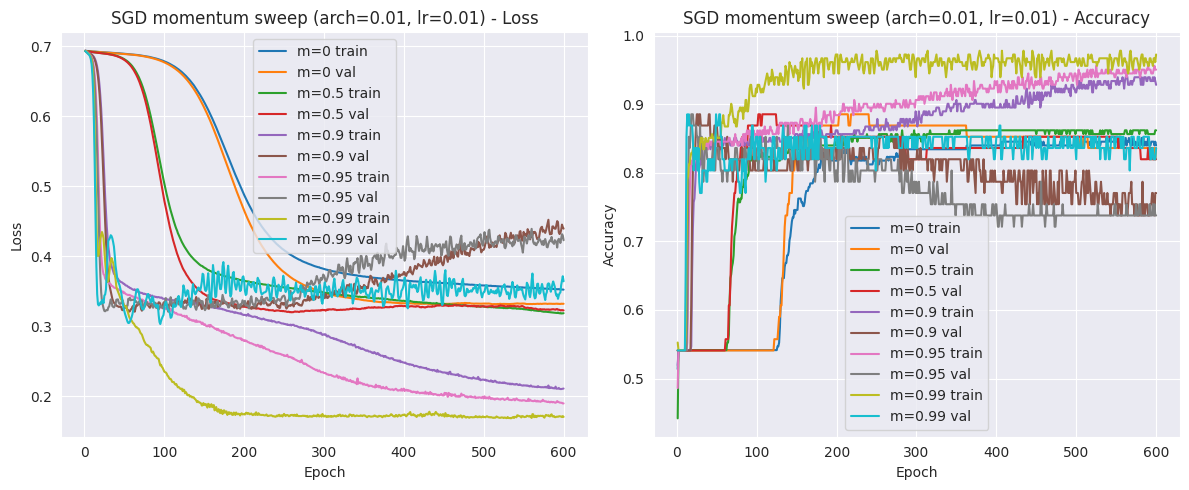

In [39]:
def make_model(hidden_sizes):
    return MLP(
        input_size=INPUT_SIZE,
        hidden_sizes=hidden_sizes,
        weight_std=WEIGHT_STD_PREV,
        bias_init=BIAS_INIT_PREV
    )

def run_sgd_momentum_sweep(
    momentums,
    hidden_sizes=None,
    lr=None,
    weight_decay=1e-4,
    epochs=EPOCHS,
    seed=123
):

    histories = {}
    rows = []

    for i, m in enumerate(momentums):
        torch.manual_seed(seed + i)
        np.random.seed(seed + i)

        model = make_model(hidden_sizes)
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=m,
            weight_decay=weight_decay
        )

        label = f"m={m:g}"
        hist = train_model(model, loss_fn, optimizer, train_loader, val_loader, epochs=epochs, device=device, verbose=False)
        histories[label] = hist

        # Final metrics
        train_loss, train_acc = hist["train_loss"][-1], hist["train_acc"][-1]
        val_loss, val_acc = hist["val_loss"][-1], hist["val_acc"][-1]
        test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
        params = sum(p.numel() for p in model.parameters())

        rows.append({
            "optimizer": "SGD",
            "arch": str(hidden_sizes),
            "lr": float(lr),
            "momentum": float(m),
            "params": int(params),
            "train_loss": float(train_loss),
            "train_acc": float(train_acc),
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc)
        })

    df = pd.DataFrame(rows).sort_values(["val_acc", "val_loss"], ascending=[False, True]).reset_index(drop=True)
    return histories, df

def report_best_sgd(df):
    best_loss = df.loc[df["val_loss"].idxmin()]
    best_acc = df.loc[df["val_acc"].idxmax()]
    print(f"SGD best by val_loss: m={best_loss['momentum']:.3f}"
          f"lr={best_loss['lr']:.5g} val_loss={best_loss['val_loss']:.4f} val_acc={best_loss['val_acc']:.3f} test_acc={best_loss['test_acc']:.3f}")
    print(f"SGD best by val_acc:  m={best_acc['momentum']:.3f}"
          f"lr={best_acc['lr']:.5g} val_loss={best_acc['val_loss']:.4f} val_acc={best_acc['val_acc']:.3f} test_acc={best_acc['test_acc']:.3f}")

# --- Configure and run the sweep ---
momentums = [0.0, 0.5, 0.9, 0.95, 0.99]
SGD_LR = LEARNING_RATE_PREV if 'LEARNING_RATE_PREV' in globals() else 1e-2

sgd_histories, sgd_df = run_sgd_momentum_sweep(
    momentums=momentums,
    hidden_sizes=HIDDEN_SIZES_PREV,
    lr=SGD_LR,
    weight_decay=WEIGHT_STD_PREV,
    epochs=EPOCHS,
    seed=777
)

print(sgd_df)
report_best_sgd(sgd_df)



plot_history(sgd_histories, title=f"SGD momentum sweep (arch={LEARNING_RATE_PREV}, lr={SGD_LR:g})", loss_cap=5)

Higher momentums learn faster at the beginning, but suffer from instability and overfitting later in training.
- Interestingly, the best test and validation accuracy, was achieved with momentums of 0 and 0.99, indicating that both no momentum and very high momentum can be effective, depending on the training dynamics.
- We will use momentum of 0 for simplicity in future experiments.

In [44]:
#ALL PARAMETERS

#SGD parameters
SGD_LR = LEARNING_RATE_PREV
SGD_HS = HIDDEN_SIZES_PREV
SGD_WSTD = WEIGHT_STD_PREV
SGD_BINIT = BIAS_INIT_PREV
SGD_MOMENTUM = 0.0

#RMSprop parameters
RMSPROP_LR = RMSPROP_BEST_LR
RMSPROP_HS = RMSPROP_BEST_HS
RMSPROP_WSTD = WEIGHT_STD_PREV
RMSPROP_BINIT = BIAS_INIT_PREV

# Adam parameters
ADAM_LR = ADAM_BEST_LR
ADAM_HS = ADAM_BEST_HS
ADAM_WSTD = WEIGHT_STD_PREV
ADAM_BINIT = BIAS_INIT_PREV

EPOCHS = 600



   optimizer  batch_size      lr  arch  params  train_loss  train_acc  \
0       Adam           4  0.0001   [8]     217    0.336655   0.850829   
1       Adam           8  0.0001   [8]     217    0.345240   0.850829   
2       Adam          16  0.0001   [8]     217    0.356640   0.845304   
3       Adam          32  0.0001   [8]     217    0.375204   0.856354   
4       Adam          64  0.0001   [8]     217    0.434366   0.828729   
5       Adam         128  0.0001   [8]     217    0.502347   0.812155   
6    RMSprop           4  0.0001   [8]     217    0.339815   0.834254   
7    RMSprop           8  0.0001   [8]     217    0.350065   0.845304   
8    RMSprop          16  0.0001   [8]     217    0.359596   0.839779   
9    RMSprop          32  0.0001   [8]     217    0.374539   0.839779   
10   RMSprop          64  0.0001   [8]     217    0.443016   0.823204   
11   RMSprop         128  0.0001   [8]     217    0.516329   0.812155   
12       SGD           4  0.0100  [16]     433    0

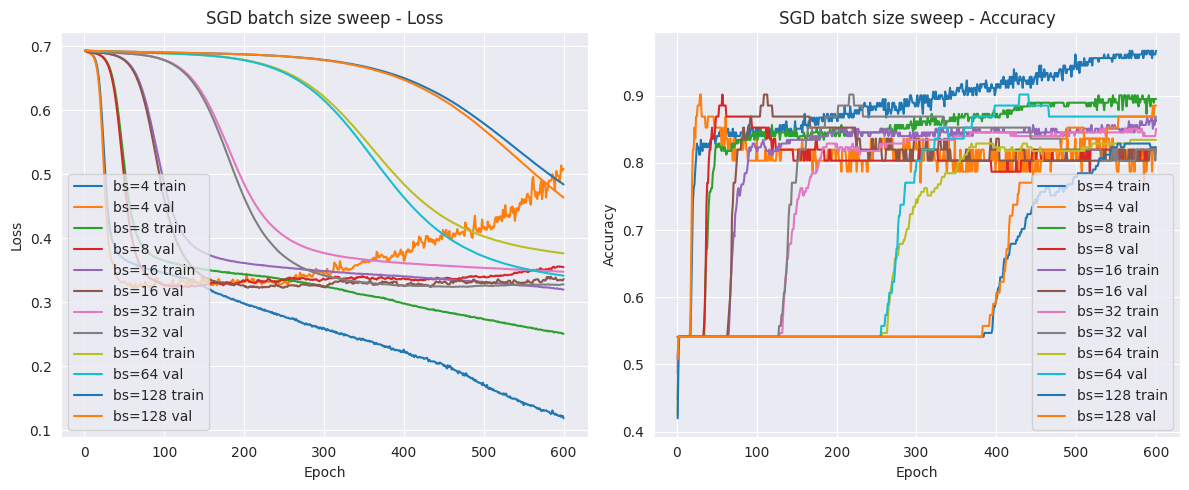

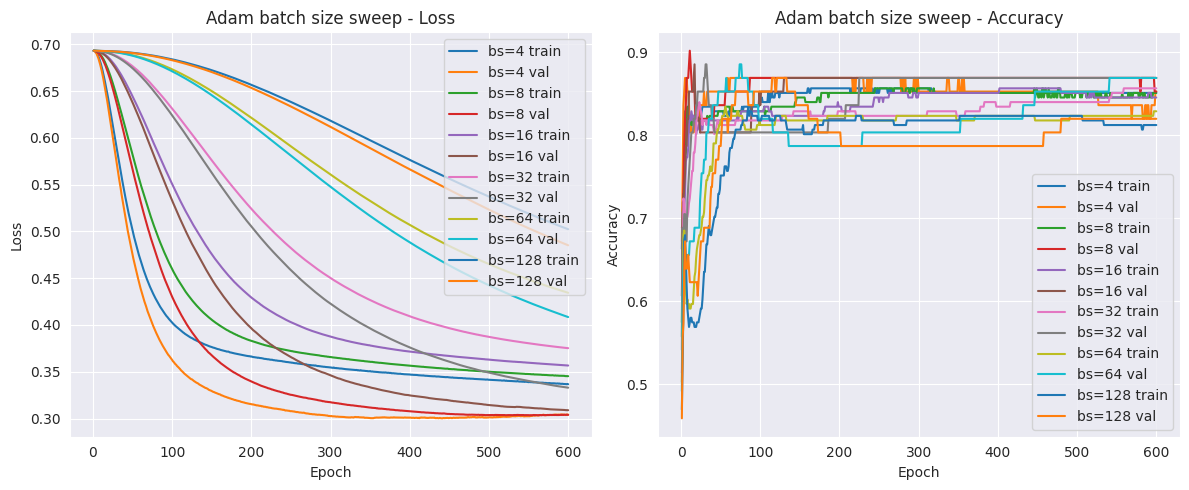

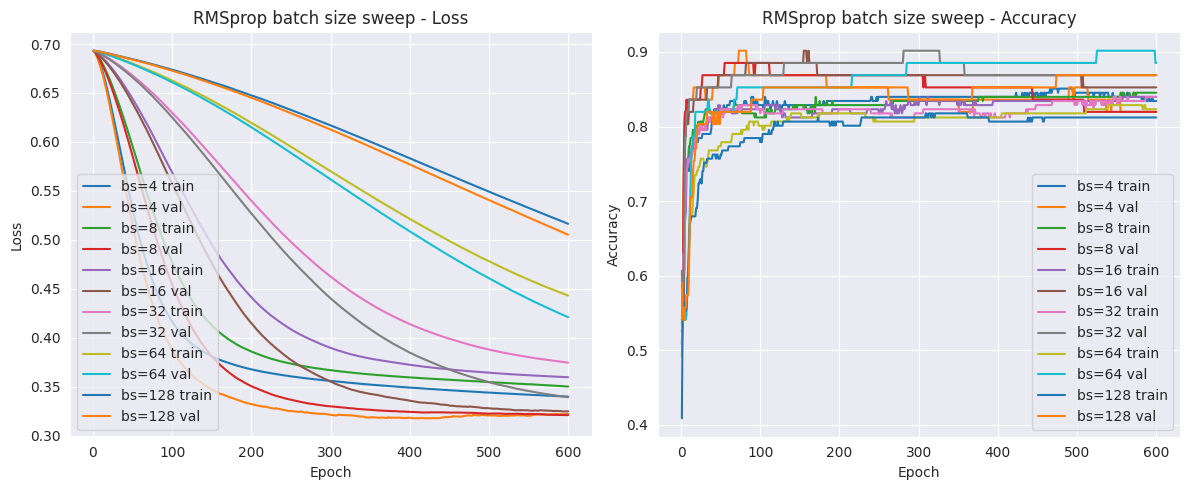

In [50]:
# Ensure test loader (use a fixed large batch size for evaluation)
test_batch_size = 256
X_test_t = torch.from_numpy(X_test_np.astype(np.float32))
y_test_t = torch.from_numpy(y_test_np.reshape(-1, 1).astype(np.float32))
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_t, y_test_t),
    batch_size=test_batch_size,
    shuffle=False
)

def make_model(hidden_sizes, wstd, binit):
    return MLP(
        input_size=X_train_np.shape[1],
        hidden_sizes=hidden_sizes,
        weight_std=wstd,
        bias_init=binit
    )

def run_batch_size_sweep(batch_sizes, epochs=EPOCHS, seed=999, weight_decay=1e-4):
    rows = []
    histories = {}
    specs = [
        ("SGD",    SGD_LR,    SGD_HS,    SGD_WSTD,    SGD_BINIT,
                  lambda m, lr: torch.optim.SGD(m.parameters(), lr=lr,
                                                momentum=SGD_MOMENTUM, weight_decay=weight_decay)),
        ("Adam",   ADAM_LR,   ADAM_HS,   ADAM_WSTD,   ADAM_BINIT,
                  lambda m, lr: torch.optim.Adam(m.parameters(), lr=lr, weight_decay=weight_decay)),
        ("RMSprop",RMSPROP_LR,RMSPROP_HS,RMSPROP_WSTD,RMSPROP_BINIT,
                  lambda m, lr: torch.optim.RMSprop(m.parameters(), lr=lr, weight_decay=weight_decay)),
    ]

    for opt_idx, (opt_name, lr, hs, wstd, binit, opt_fn) in enumerate(specs):
        histories[opt_name] = {}
        # Base init snapshot for fairness across batch sizes
        torch.manual_seed(seed + opt_idx)
        np.random.seed(seed + opt_idx)
        base_model = make_model(hs, wstd, binit)
        base_state = deepcopy(base_model.state_dict())

        for bi, bs in enumerate(batch_sizes):
            torch.manual_seed(seed + opt_idx * 100 + bi)
            np.random.seed(seed + opt_idx * 100 + bi)

            model = make_model(hs, wstd, binit)
            model.load_state_dict(base_state)
            train_loader, val_loader_local = make_dataloaders(
                X_train_np, y_train_np,
                X_val_np, y_val_np,
                batch_size=bs,
                shuffle=True
            )
            optimizer = opt_fn(model, lr)

            hist = train_model(
                model, loss_fn, optimizer,
                train_loader, val_loader_local,
                epochs=epochs, device=device, verbose=False
            )
            histories[opt_name][f"bs={bs}"] = hist

            train_loss = hist["train_loss"][-1]
            train_acc = hist["train_acc"][-1]
            val_loss = hist["val_loss"][-1]
            val_acc = hist["val_acc"][-1]
            test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
            params = sum(p.numel() for p in model.parameters())

            rows.append({
                "optimizer": opt_name,
                "batch_size": bs,
                "lr": lr,
                "arch": str(hs),
                "params": int(params),
                "train_loss": float(train_loss),
                "train_acc": float(train_acc),
                "val_loss": float(val_loss),
                "val_acc": float(val_acc),
                "test_loss": float(test_loss),
                "test_acc": float(test_acc)
            })

    df = pd.DataFrame(rows).sort_values(["optimizer", "batch_size"]).reset_index(drop=True)
    return histories, df

def summarize_batch_size_results(df):
    print("Best per optimizer (by val_acc and val_loss):")
    for opt in df["optimizer"].unique():
        sub = df[df["optimizer"] == opt]
        best_acc = sub.loc[sub["val_acc"].idxmax()]
        best_loss = sub.loc[sub["val_loss"].idxmin()]
        print(f"{opt} best val_acc: batch_size={best_acc['batch_size']} "
              f"val_acc={best_acc['val_acc']:.3f} val_loss={best_acc['val_loss']:.4f} test_acc={best_acc['test_acc']:.3f}")
        print(f"{opt} best val_loss: batch_size={best_loss['batch_size']} "
              f"val_acc={best_loss['val_acc']:.3f} val_loss={best_loss['val_loss']:.4f} test_acc={best_loss['test_acc']:.3f}")
        print("-" * 50)

def plot_batch_size_histories(histories, loss_cap=None):
    # Reuse plot_history for each optimizer
    for opt_name, hdict in histories.items():
        plot_history(hdict, title=f"{opt_name} batch size sweep", loss_cap=loss_cap)

# Usage:
batch_sizes = [4, 8, 16, 32, 64, 128]
histories_bs, results_bs_df = run_batch_size_sweep(batch_sizes)
print(results_bs_df)
summarize_batch_size_results(results_bs_df)
plot_batch_size_histories(histories_bs, loss_cap=5)


The batch size sweep across SGD, Adam, and RMSprop optimizers reveals several insights:
- The smaller the batch size, the faster the model learns, smallest batch size of 8 achieved the best validation accuracy for RMSprop and Adam.
- For SGD, with learning rate of 0.01, the batch size 8 lead to overfitting, while batch size of 32 achieved the best validation accuracy of 0.803. 

In [46]:
def make_model(hidden_sizes, wstd, binit):
    return MLP(
        input_size=X_train_np.shape[1],
        hidden_sizes=hidden_sizes,
        weight_std=wstd,
        bias_init=binit
    )

@torch.no_grad()
def make_loader(X_np, y_np, batch_size, shuffle):
    X_t = torch.from_numpy(X_np.astype(np.float32))
    y_t = torch.from_numpy(y_np.astype(np.float32))
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def cross_validate_models(
    k=5,
    batch_size_map=None,         # dict per optimizer or single int
    weight_decay=1e-4,
    epochs=EPOCHS,
    seed=2025
):
    # Combine train + val for CV
    X_cv = np.concatenate([X_train_np, X_val_np], axis=0)
    y_cv = np.concatenate([y_train_np, y_val_np], axis=0)  # shape (N,1)
    y_cv_flat = y_cv.reshape(-1)  # for StratifiedKFold

    # Prepare test loader once
    test_loader = make_loader(X_test_np, y_test_np.reshape(-1,1), batch_size=256, shuffle=False)

    optim_specs = {
        "SGD": {
            "lr": SGD_LR,
            "hs": SGD_HS,
            "wstd": SGD_WSTD,
            "binit": SGD_BINIT,
            "factory": lambda m, lr: torch.optim.SGD(m.parameters(), lr=lr,
                                                     momentum=SGD_MOMENTUM, weight_decay=weight_decay)
        },
        "Adam": {
            "lr": ADAM_LR,
            "hs": ADAM_HS,
            "wstd": ADAM_WSTD,
            "binit": ADAM_BINIT,
            "factory": lambda m, lr: torch.optim.Adam(m.parameters(), lr=lr, weight_decay=weight_decay)
        },
        "RMSprop": {
            "lr": RMSPROP_LR,
            "hs": RMSPROP_HS,
            "wstd": RMSPROP_WSTD,
            "binit": RMSPROP_BINIT,
            "factory": lambda m, lr: torch.optim.RMSprop(m.parameters(), lr=lr, weight_decay=weight_decay)
        }
    }

    # Batch size resolution
    def resolve_bs(opt_name):
        if batch_size_map is None:
            return 32
        if isinstance(batch_size_map, int):
            return batch_size_map
        return batch_size_map.get(opt_name, 32)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    all_rows = []
    histories = {opt: [] for opt in optim_specs.keys()}

    for opt_idx, (opt_name, spec) in enumerate(optim_specs.items()):
        lr = spec["lr"]; hs = spec["hs"]; wstd = spec["wstd"]; binit = spec["binit"]; make_opt = spec["factory"]
        fold_rows = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv_flat)):
            torch.manual_seed(seed + opt_idx * 100 + fold)
            np.random.seed(seed + opt_idx * 100 + fold)

            X_tr, y_tr = X_cv[train_idx], y_cv[train_idx]
            X_va, y_va = X_cv[val_idx], y_cv[val_idx]

            bs = resolve_bs(opt_name)
            train_loader = make_loader(X_tr, y_tr, batch_size=bs, shuffle=True)
            val_loader = make_loader(X_va, y_va, batch_size=bs, shuffle=False)

            # Consistent initialization across folds
            base_model = make_model(hs, wstd, binit)
            base_state = base_model.state_dict()
            model = make_model(hs, wstd, binit)
            model.load_state_dict(base_state)

            optimizer = make_opt(model, lr)
            hist = train_model(model, loss_fn, optimizer, train_loader, val_loader,
                               epochs=epochs, device=device, verbose=False)

            train_loss = hist["train_loss"][-1]
            train_acc = hist["train_acc"][-1]
            val_loss = hist["val_loss"][-1]
            val_acc = hist["val_acc"][-1]
            test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
            params = sum(p.numel() for p in model.parameters())

            row = {
                "optimizer": opt_name,
                "fold": fold,
                "lr": lr,
                "batch_size": bs,
                "arch": str(hs),
                "params": int(params),
                "train_loss": float(train_loss),
                "train_acc": float(train_acc),
                "val_loss": float(val_loss),
                "val_acc": float(val_acc),
                "test_loss": float(test_loss),
                "test_acc": float(test_acc)
            }
            fold_rows.append(row)
            histories[opt_name].append(hist)

        # Aggregate stats per optimizer
        df_opt = pd.DataFrame(fold_rows)
        agg = df_opt[["train_loss","train_acc","val_loss","val_acc","test_loss","test_acc"]].mean()
        row_summary = {
            "optimizer": opt_name,
            "lr": lr,
            "batch_size": resolve_bs(opt_name),
            "arch": str(hs),
            "params": df_opt["params"].iloc[0],
            "mean_train_loss": agg["train_loss"],
            "mean_train_acc": agg["train_acc"],
            "mean_val_loss": agg["val_loss"],
            "mean_val_acc": agg["val_acc"],
            "mean_test_loss": agg["test_loss"],
            "mean_test_acc": agg["test_acc"]
        }
        all_rows.append(row_summary)

    summary_df = pd.DataFrame(all_rows).sort_values("mean_val_acc", ascending=False).reset_index(drop=True)

    # Select best optimizer by validation accuracy
    best_row = summary_df.iloc[0]
    best_opt = best_row["optimizer"]
    # Retrain best model on full CV data (train+val combined)
    bs_best = resolve_bs(best_opt)
    full_loader = make_loader(X_cv, y_cv, batch_size=bs_best, shuffle=True)
    model_final = make_model(optim_specs[best_opt]["hs"],
                             optim_specs[best_opt]["wstd"],
                             optim_specs[best_opt]["binit"])
    optimizer_final = optim_specs[best_opt]["factory"](model_final, optim_specs[best_opt]["lr"])
    final_hist = train_model(model_final, loss_fn, optimizer_final,
                             full_loader, None, epochs=epochs, device=device, verbose=False)
    test_loader = make_loader(X_test_np, y_test_np.reshape(-1,1), batch_size=256, shuffle=False)
    final_test_loss, final_test_acc = evaluate(model_final, test_loader, loss_fn, device)

    print("Cross-validation summary:")
    print(summary_df)
    print(f"\nSelected best optimizer: {best_opt} (mean_val_acc={best_row['mean_val_acc']:.3f})")
    print(f"Final retrain test_loss={final_test_loss:.4f} test_acc={final_test_acc:.3f}")

    return summary_df, histories, model_final, final_hist

cv_summary, cv_histories, best_model, best_model_history = cross_validate_models(
    k=5,
    batch_size_map={"SGD":32, "Adam":8, "RMSprop":8},
    epochs=EPOCHS
)


Cross-validation summary:
  optimizer      lr  batch_size  arch  params  mean_train_loss  \
0   RMSprop  0.0001           8   [8]     217         0.324719   
1       SGD  0.0100          32  [16]     433         0.314696   
2      Adam  0.0001           8   [8]     217         0.320998   

   mean_train_acc  mean_val_loss  mean_val_acc  mean_test_loss  mean_test_acc  
0        0.866727       0.400644      0.830357        0.296856       0.872131  
1        0.872934       0.406847      0.826105        0.314970       0.859016  
2        0.867753       0.400133      0.822024        0.297949       0.868852  

Selected best optimizer: RMSprop (mean_val_acc=0.830)
Final retrain test_loss=0.3047 test_acc=0.869
